# APTOS 2019 Blindness Detection

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import cv2
from imgaug import augmenters as iaa
from PIL import Image

## White Noise

In [2]:
class WhiteNoise(object):
    def __init__(self, prob, scale):
        self.prob = prob
        self.seq = iaa.Sequential([
            iaa.AdditiveGaussianNoise(scale)
        ])
        
    def __call__(self, img):
        rand = np.random.rand()
        if rand > self.prob:
            arr = np.array(img)
            arr = self.seq.augment_image(arr)
            img = Image.fromarray(arr)
        return img

## RandomEraser

In [31]:
class RandomEraser(object):
    """
    """
    def __init__(self, prob, size_range=(0.02, 0.4), ratio_range=(0.3, 3)):         
        self.prob = prob         
        self.size_range = size_range  # TODO error case      
        self.ratio_range = ratio_range  
    def __call__(self, img):    
        rand = np.random.rand()    
        if rand > self.prob:
            arr = np.array(img)
            mask_value = np.random.randint(0, 256)
            h, w, _ = arr.shape      
            mask_area = np.random.randint(h * w * self.size_range[0], h * w * self.size_range[1])     
            mask_aspect_ratio = np.random.rand() * (self.ratio_range[1] - self.ratio_range[0]) + self.ratio_range[0]             
            mask_height = int(np.sqrt(mask_area / mask_aspect_ratio))    
            if mask_height > h - 1:    
                mask_height = h - 1    
            mask_width = int(mask_aspect_ratio * mask_height) 
            if mask_width > w - 1:                  
                mask_width = w - 1      
            top = np.random.randint(0, h - mask_height)     
            left = np.random.randint(0, w - mask_width)    
            bottom = top + mask_height     
            right = left + mask_width      
            arr[top:bottom, left:right].fill(mask_value)
            img = Image.fromarray(arr)
        return img

## Check

In [3]:
train_df = pd.read_csv("../input/train.csv")

In [4]:
def load_image(id):
    img_path = Path().absolute().parent / "input" / "train_images" / "{}.png".format(id)
    
    if img_path.exists():
        d_level = int(train_df.query("id_code == '{}'".format(id)).iloc[0, 1]) 
        diagnosis_dict = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}
    else:
        img_path = Path().absolute().parent / "input" / "test_images" / "{}.png".format(id)
        
    return cv2.imread(str(img_path))

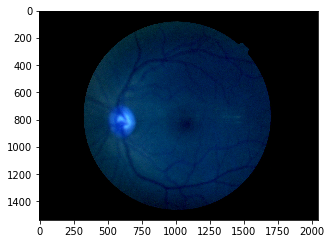

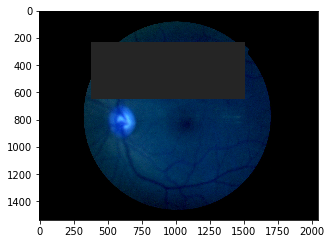

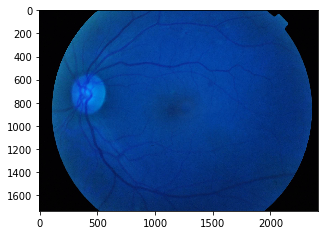

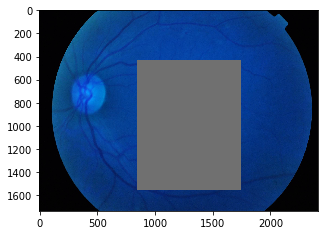

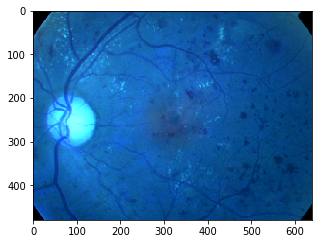

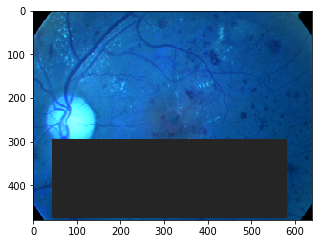

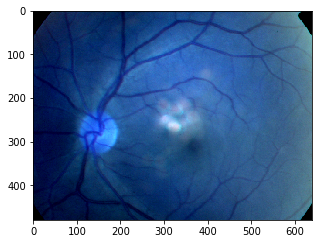

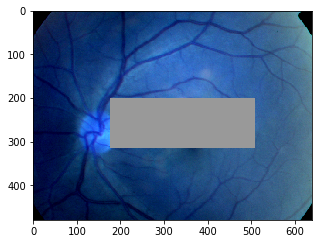

In [32]:
augment = RandomEraser(prob=0)
f_list = ["005b95c28852", "00cb6555d108", "01499815e469", "0167076e7089"]
for file_name in f_list:
    img = load_image(file_name)
    img = Image.fromarray(img)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    
    img = load_image(file_name)
    img = Image.fromarray(img)
    img = augment(img)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)